# Wine Quality
Author: Albert Wildeman

# Setup

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import scipy.stats as st
import copy
from IPython.display import display
from sklearn import preprocessing, svm, metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.feature_selection import RFECV
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Graphics
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(0)

In [2]:
# Create list of wine colors
clrs  = ['red', 'white']
n_clrs = len(clrs)
# plotting colors for red, white wine
plot_colors = [(0.65, 0, 0.10), (0.93, 0.96, 0.88)]
# define names for the criteria to be looked at
criteria = ['excellent', 'poor']
n_criteria = len(criteria)

In [3]:
# Define a plotting function for later use
def plot_histograms(dfs, ttl):
    fig = plt.figure(figsize=(15,5))
    for i_feat, feat in enumerate(feats):

        ax = plt.subplot2grid((3,4),divmod(i_feat,4))
        ax.hist([df[feat].values for df in dfs], 10, normed=1, histtype='bar', 
                color=plot_colors, label=clrs)
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', 
                        labelleft='off', labelbottom='off')
        plt.title(feat)
        
    ax = plt.subplot2grid((3,4),(2,3)) #The last subplot is used only to display the legend
    ax.hist([[0],[0]], color=plot_colors, label=clrs); ax.set_ylim(-2,-1); ax.axis('off'); 
    ax.legend(prop={'size': 10}, loc=4)
    st = plt.suptitle(ttl, size='15', y=1.05)
    plt.tight_layout();

# Load data

In [4]:
dfs = [ pd.read_csv("data/winequality-" + clr + ".csv", sep = ';') for clr in clrs]
# Generate list of features
feats = dfs[0].drop('quality', axis=1).columns.values
# Get number of features &  (for each color) observations
n_feats = len(feats)

# Distribution of quality ratings and features

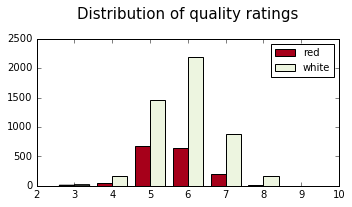

In [5]:
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
arr = ax.hist([df.quality.values for df in dfs], np.arange(2.5, 10.5), histtype='bar',
              color=plot_colors, label=clrs)
ax.legend(prop={'size': 10})
plt.title('Distribution of quality ratings', size='15', y=1.10)
plt.tight_layout();

Given the tiny number of wines rated above 8 or below 4, the 'excellent' category will include all wines rated higher than 7, and the 'poor' category will include all wines rated below 5.

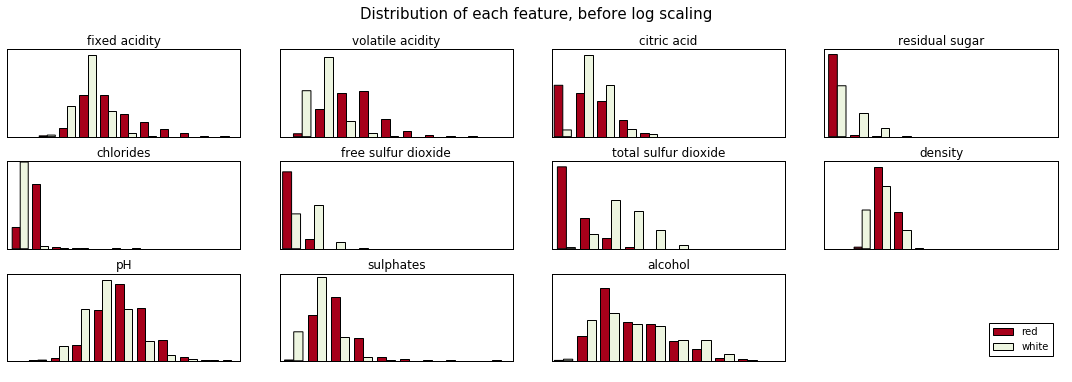

In [6]:
plot_histograms(dfs, 'Distribution of each feature, before log scaling')

# Preparation of the data for model fitting

## Missing values

In [7]:
for i_clr, clr in enumerate(clrs):
    print('Missing values in ' + clr + ' wine data: ' + str(dfs[i_clr].isnull().sum().sum()))

Missing values in red wine data: 0
Missing values in white wine data: 0


## Log scaling
Because the distribution of some of the variables is rather skewed, those variables are subjected to log scaling:

In [8]:
# Set features to log-transform
skewed_feats = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
                'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']
# log transform
for df in dfs:
    df[skewed_feats] = np.log1p(df[skewed_feats])

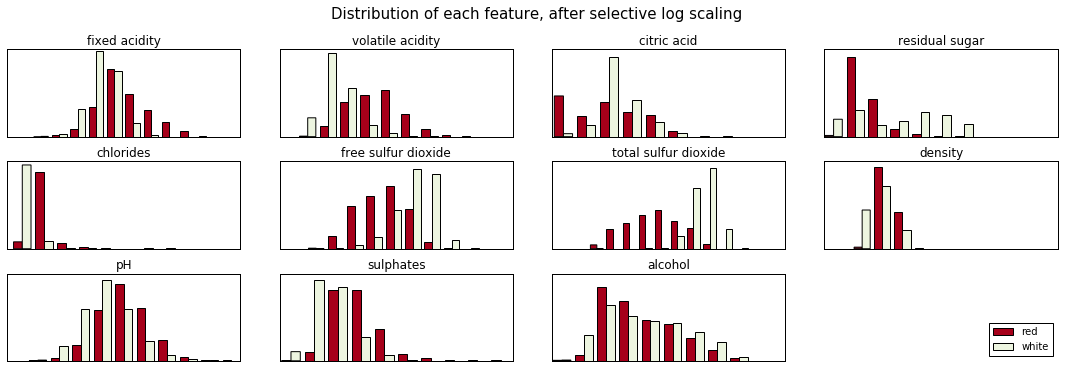

In [9]:
plot_histograms(dfs, 'Distribution of each feature, after selective log scaling')

## Outliers

In [10]:
# Candidates for outliers:
inspect = ['chlorides','density']
for feat in inspect:
    for i_clr in range(n_clrs):
        print('5 largest values for ' + feat + ' (' + clrs[i_clr] + '): ', np.sort(dfs[i_clr][feat].values)[-5:])

5 largest values for chlorides (red):  [ 0.35206433  0.38117242  0.3832195   0.47623418  0.4768551 ]
5 largest values for chlorides (white):  [ 0.22713557  0.23980399  0.25464222  0.2631332   0.29713723]
5 largest values for density (red):  [ 1.00315  1.00315  1.0032   1.00369  1.00369]
5 largest values for density (white):  [ 1.00295  1.00295  1.0103   1.0103   1.03898]


Of these, the white wine with the largest value for density is the most concerning. Inspect the quality of this wine:

In [11]:
print('Quality of candidate for deletion: ', dfs[1].loc[np.where(dfs[1].density==1.03898)[0],'quality'].values[0])    

Quality of candidate for deletion:  6


This is neither poor nor excellent, and therefore not a particularly valuable datapoint which can be deleted.

In [12]:
dfs[1] = dfs[1].loc[np.where(dfs[1].density!=1.03898)[0],:]

## Normalization: mean-centering and variance scaling
One of the benefits of normalization is that it allows regularized linear models such as Lasso or Ridge Regression to penalize the various feautures evenly.

In [ ]:
X = [preprocessing.StandardScaler().fit_transform(dfs[i_clr][feats]) for i_clr in range(n_clrs)]
# The target vector does not need to be scaled, but is constructed here as well:
y = [[(df.quality.values>7)*1 for df in dfs], [(df.quality.values<5)*1 for df in dfs]]

# Model fitting & evaluation
Models to predict excellent wines have very different applications from those predicting poor ones: the latter could applied in tuning the production process in pursuit of ever better wines, whereas the latter could be used for quality assurance.

In either case, the most important thing is that none of wines of interest (whether excellent or poor) are missed by the model; false positives are of lesser importance. Performance in this sense is measured by recall, defined as the percentage of excellent/poor wines which are identified as such.
Though secondary, false positives are still of interest, and are summarized here by precision. Precision is the percentage of wines selected by the model that truly are excellent/poor.

In [ ]:
# Set up possible values of parameters to optimize over
p_grid = {"C": [.1, 1, 10],
          "gamma": [.01, .05, .1]}
# Use a Support Vector Classifier
svc = svm.SVC(kernel="linear", class_weight='balanced')

feat_sel = pd.DataFrame(columns = feats, dtype=bool)
performance = pd.DataFrame(columns = ['recall', 'precision'])

for i_crit in range(n_criteria):
    for i_clr in range(n_clrs):
        selector = RFECV(estimator=svc,  scoring = 'recall').fit(X[i_clr], y[i_crit][i_clr])
        feat_sel.loc[criteria[i_crit] + ' ' + clrs[i_clr], :] = selector.support_
        clf = GridSearchCV(estimator=svc, param_grid=p_grid, cv=3, scoring = 'recall')
        # Nested CV with parameter optimization
        predicted = cross_val_predict(clf, X[i_clr][:,selector.support_], y[i_crit][i_clr], cv=4)
        performance.loc[criteria[i_crit] + ' ' + clrs[i_clr], :] = [metrics.recall_score(y[i_crit][i_clr], predicted),
                                                                    metrics.precision_score(y[i_crit][i_clr], predicted)]
        # Get feature importance (fit model on entire dataset)
        coefs = svc.fit(X[i_clr][:,selector.support_], y[i_crit][i_clr]).coef_
        feat_sel.loc[criteria[i_crit] + ' ' + clrs[i_clr], selector.support_] = [str(int(round(abs(x)*100))) for x in coefs[0]]
        
performance = performance.applymap(lambda x: str(int(round(x*100)))+'%')

print('Performance of detection models for excellent and poor wines: ')
performance

The precision of these models is disappointing. In part this is due to the prioritization of recall, but the limited number of excellent and poor wines in the dataset is also a factor (particularly in the case of excellent red wines).
## Feature importance
The models used here include automatic feature selection, and the features selected for each are quite different. The following table lists which features are included for each model, and an indication of the importance of the included features. The importance displayed is on an arbitrary scale.

In [ ]:
feat_sel

# Clusters


## Dendrogram


In [ ]:
# do scaling like before, but now include quality
scalers = [preprocessing.StandardScaler().fit(dfs[i_clr]) for i_clr in range(n_clrs)]
X_cl = [scalers[i_clr].transform(dfs[i_clr]) for i_clr in range(n_clrs)]

In [ ]:
# generate dendrograms
Z = [linkage(X_cl[i_clr], 'ward') for i_clr in range(n_clrs)]
fig = plt.figure(figsize=(15,4))
for i_clr in range(n_clrs):
    ax = plt.subplot2grid((1,2),(0,i_clr)).set(xlabel='samples', ylabel='distance', title=(clrs[i_clr] + ' wine'))
    dendrogram(Z[i_clr], leaf_label_func= lambda x : '')
plt.suptitle('Dendrograms', size='15', y=1.05);

Judging by the height of the merges, as well as the automatic coloring of the dendrogram (based on 70% of the final merge distance), the red and white wines most naturally split into 2 and 3 clusters, respectively.

## A look at the clusters
A look at the data, color-coded by cluster, in terms of the two density and alcohol content. These features are used because they are relevant in most of the models created above.

In [ ]:
n_clusters = [3,2]
plot_feats = ['density', 'alcohol']

# Scale back the data
X_orig = [pd.DataFrame(scalers[i_clr].inverse_transform(X_cl[i_clr]), columns=dfs[i_clr].columns) for i_clr in range(n_clrs)]
for i_clr in range(n_clrs):
    X_orig[i_clr][skewed_feats] = np.expm1(X_orig[i_clr][skewed_feats][skewed_feats])
    
fig = plt.figure(figsize=(15,4))
for i_clr in range(n_clrs):
    clusters = fcluster(Z[i_clr], n_clusters[i_clr], criterion='maxclust')
    ax = plt.subplot2grid((1,2),(0,i_clr))
    plt.scatter(X_orig[i_clr][plot_feats[0]], X_orig[i_clr][plot_feats[1]], c=clusters, cmap='rainbow', alpha=0.8, s=25)
    ax.set(xlim=(.985,1.005), ylim=(7.5,15.5), xlabel=plot_feats[0], ylabel=plot_feats[1], title=clrs[i_clr]+' wine')
plt.suptitle('Clusters', size='15', y=1.05);